# Importing data + Setup

The easiest way to execute this project is simply run all cells. The datasets are included in the folder contained in the same zip-archive.

The datasets used for training and inference can be alternated in the cell below.

In [449]:
import os
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [450]:
pd.set_option('display.max_columns', None)          # stops pandas from truncating columns

In [451]:
print(os.listdir("datasets/"))  
openstackDataset = pd.read_csv("datasets/openstack_metrics.csv")
qtDataset = pd.read_csv("datasets/qt_metrics.csv")

['openstack_metrics.csv', 'qt_metrics.csv']


In [452]:
# pick datasets for training and inference testing, this allows for easy switching between them
trainingDataset = openstackDataset
inferenceDataset = qtDataset

In [453]:
# removing unnecessary attributes early since they hinder analysis-functions like correlation matrices
trainingDataset = trainingDataset.drop(['commit_id', 'author_date'], axis=1)   
inferenceDataset = inferenceDataset.drop(['commit_id', 'author_date'], axis=1) 

# Understanding the data

### Understanding each feature of the datasets

In [454]:
#0 commit_id :      unique id for the commited code                                #16 ndev :   N of devs that have modied the file in the past
#1 author_date :    id for the author of the commit                                #17 age :    time since previous update to the file
#2 bugcount :       amount of bugs detected                                        #18 nuc :    N of prior(unique) changes to the file
#3 fixcount :       amount of fixes                                                #19 app :    N of reviewers who voted on integration
#4 la :             lines added                                                    #20 aexp :   N of changes author has participated in
#5 ld :             lines deleted                                                  #21 rexp :   aexp but reviewer instead of author
#6 nf :             modified files                                                 #22 oexp :   o?
#7 nd :             modified directories                                           #23 arexp :  aexp but weighted by recency of changes
#8 ns :             modified subsystems                                            #24 rrexp :  arexp but reviewer instead of author
#9 ent :            entropy, spread of modified lines across files                 #25 orexp :  o?
#10 revd :          reviewed/revised? revd=False -> rxxx=NaN                       #26 asexp :  N of changes within the subsystem from the author
#11 nrev :          N of revisions to the commit                                   #27 rsexp :  asexp but reviewer instead of author
#12 rtime :         time between commit and approval                               #28 osexp :  o?
#13 tcmt :          total comments on the commit?                                  #29 asawr :  Proportion of previous changes to the subsystem from the author
#14 hcmt :          N of non-automated comments during review                      #30 rsawr :  asawr but reviewer instead of author
#15 self :          only self-checked? inverse of revd                             #31 osawr :  o?

In [455]:
trainingDataset.sample(3)

bugcount  fixcount  la  ld  nf  nd  ns       ent   revd  nrev  rtime  \
13374       NaN       NaN  67   0   1   1   1  0.000000  False   NaN    NaN   
14626       NaN       NaN   3   2   1   1   1  0.000000  False   NaN    NaN   
7077        NaN       NaN  20   7   5   3   1  0.754853  False   NaN    NaN   

       tcmt  hcmt  self  ndev  age  nuc  app  aexp  rexp  oexp  arexp  rrexp  \
13374   NaN   NaN  True   NaN  NaN  NaN  NaN   NaN   NaN   NaN    NaN    NaN   
14626   NaN   NaN  True   NaN  NaN  NaN  NaN   NaN   NaN   NaN    NaN    NaN   
7077    NaN   NaN  True   NaN  NaN  NaN  NaN   NaN   NaN   NaN    NaN    NaN   

       orexp  asexp  rsexp  osexp  asawr  rsawr  osawr  
13374    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
14626    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
7077     NaN    NaN    NaN    NaN    NaN    NaN    NaN

In [456]:
inferenceDataset.sample(3)

bugcount  fixcount  la  ld  nf  nd  ns  ent  revd  nrev     rtime  \
19852       NaN       NaN  18  14   1   1   1  0.0  True   1.0   29792.0   
18704       NaN       NaN   1   1   1   1   1  0.0  True   1.0  112224.0   
31260       NaN       NaN   3   0   1   1   1  0.0  True   3.0   99662.0   

       tcmt  hcmt   self  ndev        age   nuc  app   aexp    rexp    oexp  \
19852   5.0   1.0  False   3.0  1708072.0   3.0  2.0   76.0   171.0   171.0   
18704   8.0   1.0  False   1.0  1817939.0   1.0  2.0  776.0  1224.0  1224.0   
31260  12.0   6.0  False   8.0    11628.0  21.0  2.0   19.0   548.0   557.0   

       arexp  rrexp  orexp  asexp   rsexp   osexp     asawr     rsawr  \
19852   76.0  171.0  171.0   20.0    58.0    58.0  0.019811  0.055660   
18704  540.0  856.0  856.0  699.0  1125.0  1125.0  0.044131  0.070987   
31260   19.0  547.0  556.0    5.0   168.0   169.0  0.002555  0.071976   

          osawr  
19852  0.055660  
18704  0.070987  
31260  0.072402

### Visualising and analysing the datasets

In [457]:
print("Shape of training dataset:", trainingDataset.shape)
print("Shape of training dataset:", inferenceDataset.shape)

Shape of training dataset: (26855, 30)
Shape of training dataset: (32155, 30)


In [458]:
#data.isna().sum()           # sums the amount of NaN values for each attribute
#data.describe()             # basic statistics for each attribute
#data.nunique()              # amount of unique values for each attribute
trainingDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26855 entries, 0 to 26854
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   bugcount  3235 non-null   float64
 1   fixcount  1904 non-null   float64
 2   la        26855 non-null  int64  
 3   ld        26855 non-null  int64  
 4   nf        26855 non-null  int64  
 5   nd        26855 non-null  int64  
 6   ns        26855 non-null  int64  
 7   ent       26855 non-null  float64
 8   revd      26855 non-null  bool   
 9   nrev      14562 non-null  float64
 10  rtime     14562 non-null  float64
 11  tcmt      14562 non-null  float64
 12  hcmt      14522 non-null  float64
 13  self      26855 non-null  bool   
 14  ndev      14494 non-null  float64
 15  age       14494 non-null  float64
 16  nuc       14494 non-null  float64
 17  app       14494 non-null  float64
 18  aexp      14494 non-null  float64
 19  rexp      14494 non-null  float64
 20  oexp      14494 non-null  fl

In [459]:
inferenceDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32155 entries, 0 to 32154
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   bugcount  3027 non-null   float64
 1   fixcount  3333 non-null   float64
 2   la        32155 non-null  int64  
 3   ld        32155 non-null  int64  
 4   nf        32155 non-null  int64  
 5   nd        32155 non-null  int64  
 6   ns        32155 non-null  int64  
 7   ent       32155 non-null  float64
 8   revd      32155 non-null  bool   
 9   nrev      29256 non-null  float64
 10  rtime     29256 non-null  float64
 11  tcmt      29256 non-null  float64
 12  hcmt      28283 non-null  float64
 13  self      32155 non-null  bool   
 14  ndev      29239 non-null  float64
 15  age       29239 non-null  float64
 16  nuc       29239 non-null  float64
 17  app       29239 non-null  float64
 18  aexp      29239 non-null  float64
 19  rexp      29239 non-null  float64
 20  oexp      29239 non-null  fl

In [460]:
print("Amount of instances where the commit was reviewed/revised in training dataset:", trainingDataset.revd.value_counts())
print("Amount of instances where the commit was reviewed/revised in inference dataset:", inferenceDataset.revd.value_counts())

Amount of instances where the commit was reviewed/revised in training dataset: revd
True     14562
False    12293
Name: count, dtype: int64
Amount of instances where the commit was reviewed/revised in inference dataset: revd
True     29256
False     2899
Name: count, dtype: int64


Spread of bugs found in the training dataset (does not include instances of NaN)


<Axes: xlabel='bugcount', ylabel='count'>

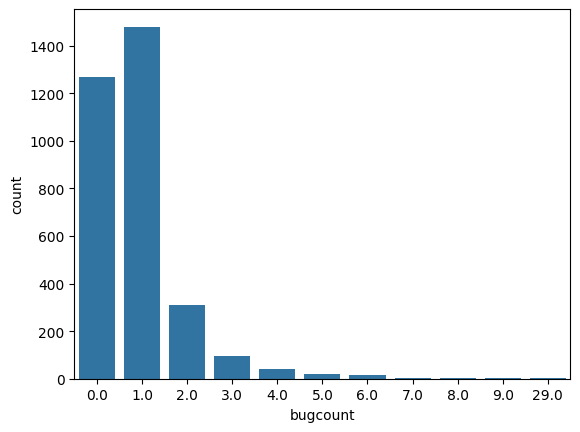

In [461]:
print("Spread of bugs found in the training dataset (does not include instances of NaN)")
sns.countplot(x='bugcount', data=trainingDataset)             

In [462]:
bugsFoundInstances = trainingDataset.bugcount.value_counts().sum() - trainingDataset.bugcount.value_counts().get(0.0)

print("Amount of instances of bugcount containing NaN:", trainingDataset.bugcount.isna().sum())
print(f"Amount of times bugs were detected: {bugsFoundInstances} out of {trainingDataset.shape[0]} instances")

Amount of instances of bugcount containing NaN: 23620
Amount of times bugs were detected: 1968 out of 26855 instances


### Analysing correlation between features

In [463]:
correlation_matrix = trainingDataset.corr()
high_correlations = correlation_matrix[(correlation_matrix > 0.9) | (correlation_matrix < -0.9)]

# Print correlation for each combination of features
for col in high_correlations.columns:
    # filter out correlation values for columns with themselves by setting them to NaN
    high_correlations.loc[col, col] = np.nan
    # Drop all correlations that are set as NaN
    correlations = high_correlations[col].dropna()

    if not correlations.empty:
        print(f"Correlations with {col}:")
        print(correlations)
        print()

Correlations with revd:
self   -0.98616
Name: revd, dtype: float64

Correlations with self:
revd   -0.98616
Name: self, dtype: float64

Correlations with ndev:
nuc    0.938866
Name: ndev, dtype: float64

Correlations with nuc:
ndev    0.938866
Name: nuc, dtype: float64

Correlations with aexp:
arexp    0.990452
asexp    0.914171
Name: aexp, dtype: float64

Correlations with rexp:
oexp     0.967153
rrexp    0.992474
orexp    0.959207
rsexp    0.920426
Name: rexp, dtype: float64

Correlations with oexp:
rexp     0.967153
rrexp    0.959184
orexp    0.992205
osexp    0.919459
Name: oexp, dtype: float64

Correlations with arexp:
aexp     0.990452
asexp    0.903667
Name: arexp, dtype: float64

Correlations with rrexp:
rexp     0.992474
oexp     0.959184
orexp    0.965563
rsexp    0.910773
Name: rrexp, dtype: float64

Correlations with orexp:
rexp     0.959207
oexp     0.992205
rrexp    0.965563
osexp    0.910107
Name: orexp, dtype: float64

Correlations with asexp:
aexp     0.914171
arexp   

In [464]:
trainingDataset.corr()['revd']

bugcount    0.067335
fixcount   -0.012860
la          0.000497
ld         -0.001985
nf          0.040030
nd          0.080806
ns         -0.002137
ent         0.194346
revd        1.000000
nrev             NaN
rtime            NaN
tcmt             NaN
hcmt             NaN
self       -0.986160
ndev             NaN
age              NaN
nuc              NaN
app              NaN
aexp             NaN
rexp             NaN
oexp             NaN
arexp            NaN
rrexp            NaN
orexp            NaN
asexp            NaN
rsexp            NaN
osexp            NaN
asawr            NaN
rsawr            NaN
osawr            NaN
Name: revd, dtype: float64

In [465]:
print("Amount of False-values in revd:", (trainingDataset.revd == False).sum())
print(trainingDataset[trainingDataset['revd'] == 0].isna().sum())

Amount of False-values in revd: 12293
bugcount    11888
fixcount    11672
la              0
ld              0
nf              0
nd              0
ns              0
ent             0
revd            0
nrev        12293
rtime       12293
tcmt        12293
hcmt        12293
self            0
ndev        12293
age         12293
nuc         12293
app         12293
aexp        12293
rexp        12293
oexp        12293
arexp       12293
rrexp       12293
orexp       12293
asexp       12293
rsexp       12293
osexp       12293
asawr       12293
rsawr       12293
osawr       12293
dtype: int64


# Cleaning the data

### Notes on replacing NaN values

Instances of NaN in bugcount/fixcount are assumed to imply that 0 bugs/fixes were recorded.

Based on correlation analysis of ['revd'], the remaining instances of NaN are all from features related to reviews/revisions of the commit
 
These instances are NaN iff ['revd'] = False, implying no review was made to the commit -> all review related features are therefore NaN

Replacing NaN with 0 is not equally suitable for all of these features, but is done for simplicity, example:

* ['app'] = 0, implies that no reviewers voted on integration when there was no review to vote on, this seems suitable

* ['aexp'] = 0, implies the author has participated in 0 previous changes, which is not necessarily true, not so suitable

Given more time, this could be better adapted and customized to the dataset

### Cleaning of training dataset

In [466]:
# Removing all "r" and "o" feature-types
# they contain highly correlated data, increases dimensional complexity, and rank very low on feature importance when training
unnecessaryColumns = ['arexp', 'self', 'revd', 'rexp', 'rrexp', 'rsexp', 'rsawr', 'oexp', 'orexp', 'osexp', 'osawr', 'asawr', 'asexp', 'aexp']
trainingDataset = trainingDataset.drop(unnecessaryColumns, axis=1)

# For the remaining features containing NaN, NaN are assumed to imply 0, see argument above
trainingDataset = trainingDataset.fillna(0.0)              

# turn bugcount into binary feature instead of multi-class 
trainingDataset['bugcount'] = trainingDataset['bugcount'].apply(lambda x: 1 if x != 0 else 0)

### Repeated cleaning for inference dataset

In [467]:
inferenceDataset = inferenceDataset.drop(unnecessaryColumns, axis=1)
inferenceDataset = inferenceDataset.fillna(0.0) 

inferenceDataset['bugcount'] = inferenceDataset['bugcount'].apply(lambda x: 1 if x != 0 else 0)

# extract target feature ['bugcount'] for inference testing
inference_bugcount = inferenceDataset.bugcount     
inference_set = inferenceDataset.drop(['bugcount'], axis=1) 

# Modelling

In [468]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [469]:
# import data and extract target feature before balancing 
training_data = trainingDataset
target_feature = training_data.bugcount
training_data = training_data.drop(['bugcount'], axis=1)

# show class ratio
print(target_feature.value_counts())

bugcount
0    24887
1     1968
Name: count, dtype: int64


#### Standardizing features and splitting datasets

In [470]:
# splitting dataset into test and train sets
x_train, x_test, y_train, y_test = train_test_split(training_data, target_feature, test_size=0.1, random_state=100)
features_names = x_train.columns

In [471]:
# Standardizing features to values [-1, 1], can help some models accurately depict features during training
# Example: SVM models are sensitive to the scale of features, especially SVMs with linear kernels. 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# calculates variance and mean for each feature before transforming
x_train = sc.fit_transform(x_train) 
# transforms features using the same variance and mean on both test and inference sets
x_test = sc.transform(x_test)  
inference_set = sc.transform(inference_set)

# transform numpyarray back into dataframe with correct feature names
x_train = pd.DataFrame(x_train, columns=features_names)
x_test = pd.DataFrame(x_test, columns=features_names)
inference_set = pd.DataFrame(inference_set, columns=features_names)

#### Synthetic Minority Oversampling Technique (SMOTE)

Bugcount is vastly imbalanced, this is solved by increasing the ratio of instances with found bugs. 

* Oversampling: SMOTE chooses random samples of minority class, finds similar instances of data using k-nearest neighbor and generates a new instance between the original sample and one random neighbor.

* Undersampling: Randomly undersamples data with majority class, in this case instances were bugcount = 0

In [472]:
# prepare pipeline for balancing
# multiple different ratios for sampling strategies can be tested
oversample = SMOTE(sampling_strategy=0.5)                        
undersample = RandomUnderSampler(sampling_strategy=1)
steps = [('over', oversample), ('under', undersample)]
pipeline = Pipeline(steps=steps)

# balance bugcount class
x_train, y_train = pipeline.fit_resample(x_train, y_train)
# show new balanced class ratio
print(y_train.value_counts())

bugcount
0    11197
1    11197
Name: count, dtype: int64


## Training and validation

#### RandomForestClassifier model, validated using k-fold Cross Validation

In [473]:
# specify classifier model
rfc_model = RandomForestClassifier(n_estimators=25)     #25->100, marginally better but large impact on compute

# define k-fold strategy and perform crossvalidation
crossValidation = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)     # 10 splits is a good bias-variance balance
scores = cross_val_score(rfc_model, x_train, y_train, scoring='f1_macro', cv=crossValidation, n_jobs=-1)   
print(f"CrossVal mean f1_macro: {np.mean(scores): .3f}")         # f1_macro scores adds weights to results from each class

# train RandomForestClassifier model
rfc_model.fit(x_train, y_train)

# inference on test set
rfc_predictions = rfc_model.predict(x_test)
print(f"Trained model f1-score: {f1_score(y_test, rfc_predictions): .3f}")

CrossVal mean f1_macro:  0.910
Trained model f1-score:  0.340


#### Support Vector Classifier model

In [474]:
# kernel alternatives: 'linear', 'rbf', 'poly' and 'sigmoid'
svm_model = SVC(kernel='rbf')    
svm_model.fit(x_train, y_train)
svm_predictions = svm_model.predict(x_test)
svm_f1 = f1_score(y_test, svm_predictions)
print("SVM f1 score:", svm_f1)

SVM f1 score: 0.2783410138248848


#### Naive Bayes model, GaussianNB

In [475]:
# This type of model also performs much better using standardized features
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)
nb_predictions = nb_model.predict(x_test)
nb_f1 = f1_score(y_test, nb_predictions)
print("Naive Bayes f1 score:", nb_f1)

Naive Bayes f1 score: 0.33807829181494664


# Results

### Model performance from training

In [476]:
# Metrics for RandomForestClassifier
print(classification_report(y_test, rfc_predictions, target_names=['no bugs', 'contains bugs']))

               precision    recall  f1-score   support

      no bugs       0.96      0.89      0.92      2493
contains bugs       0.26      0.50      0.34       193

     accuracy                           0.86      2686
    macro avg       0.61      0.70      0.63      2686
 weighted avg       0.91      0.86      0.88      2686



In [477]:
# Metrics for SupportVectorMachine
print(classification_report(y_test, svm_predictions, target_names=['no bugs', 'contains bugs']))

               precision    recall  f1-score   support

      no bugs       0.98      0.70      0.82      2493
contains bugs       0.17      0.78      0.28       193

     accuracy                           0.71      2686
    macro avg       0.57      0.74      0.55      2686
 weighted avg       0.92      0.71      0.78      2686



In [478]:
# Metrics for GaussianNB
print(classification_report(y_test, nb_predictions, target_names=['no bugs', 'contains bugs']))

               precision    recall  f1-score   support

      no bugs       0.96      0.89      0.92      2493
contains bugs       0.26      0.49      0.34       193

     accuracy                           0.86      2686
    macro avg       0.61      0.69      0.63      2686
 weighted avg       0.91      0.86      0.88      2686



### Model performance on inference dataset

In [479]:
# Model alternatives: rfc_model, svm_model or nb_model
rfc_inference = rfc_model.predict(inference_set)
print(classification_report(inference_bugcount, rfc_inference, target_names=['no bugs', 'contains bugs'])) 

               precision    recall  f1-score   support

      no bugs       0.94      0.95      0.95     29890
contains bugs       0.23      0.18      0.20      2265

     accuracy                           0.90     32155
    macro avg       0.59      0.57      0.58     32155
 weighted avg       0.89      0.90      0.89     32155



In [480]:
svm_inference = svm_model.predict(inference_set)
print(classification_report(inference_bugcount, svm_inference, target_names=['no bugs', 'contains bugs'])) 

               precision    recall  f1-score   support

      no bugs       0.95      0.75      0.84     29890
contains bugs       0.12      0.45      0.19      2265

     accuracy                           0.73     32155
    macro avg       0.53      0.60      0.51     32155
 weighted avg       0.89      0.73      0.79     32155



In [481]:
nb_inference = nb_model.predict(inference_set)
print(classification_report(inference_bugcount, nb_inference, target_names=['no bugs', 'contains bugs'])) 

               precision    recall  f1-score   support

      no bugs       0.94      0.96      0.95     29890
contains bugs       0.21      0.14      0.17      2265

     accuracy                           0.90     32155
    macro avg       0.57      0.55      0.56     32155
 weighted avg       0.89      0.90      0.89     32155



# Analysis

#### Calculate baseline: what are the odds of finding a bug in general?

In [482]:
# Baseline prediction for different datasets: for training_data use: target_feature | for inference_data use: inference_bugcount 
count_zero = inference_bugcount.value_counts().get(0)
count_one = inference_bugcount.value_counts().get(1)
totalCount = count_one + count_zero
chance_zero = count_zero / totalCount
chance_one = count_one / totalCount
randomGuessAccuracy = (chance_zero + chance_one) / 2
weightedGuessAccuracy = (chance_one * chance_one) + (chance_zero * chance_zero)
print(f"Bugcount values, 0: {count_zero}, 1: {count_one}")
print(f"Probability of majority class, p(0): {chance_zero:.3f}")
print(f"Propability of minority class, p(1): {chance_one:.3f}")
print(f"Accuracy of a random guess: {randomGuessAccuracy:.3f}")
print(f"Accuracy of a weighted guess: {weightedGuessAccuracy:.3f}")

Bugcount values, 0: 29890, 1: 2265
Probability of majority class, p(0): 0.930
Propability of minority class, p(1): 0.070
Accuracy of a random guess: 0.500
Accuracy of a weighted guess: 0.869


#### Feature importance from training

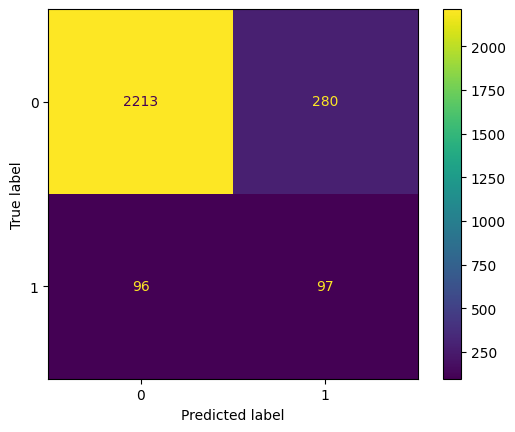

In [483]:
ConfusionMatrixDisplay.from_estimator(rfc_model, x_test, y_test) 

In [484]:
feature_importance = pd.Series(rfc_model.feature_importances_, index=x_train.columns).sort_values(axis = 0, ascending = False)
feature_importance

la          0.165989
hcmt        0.089431
nd          0.087910
ent         0.087860
nf          0.084659
tcmt        0.078918
nrev        0.069360
ld          0.068778
age         0.057544
app         0.051604
ndev        0.050268
rtime       0.042981
nuc         0.039170
fixcount    0.014036
ns          0.011493
dtype: float64